In [1]:
import pandas as pd

x_train = pd.read_csv('Dataset/x_train_all.csv')
y_train = pd.read_csv('Dataset/y_train_all.csv')

merged_df = pd.concat([x_train, y_train], axis=1)




In [2]:
data = x_train.iloc[1:9690]

x_train.iloc[:1]

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0


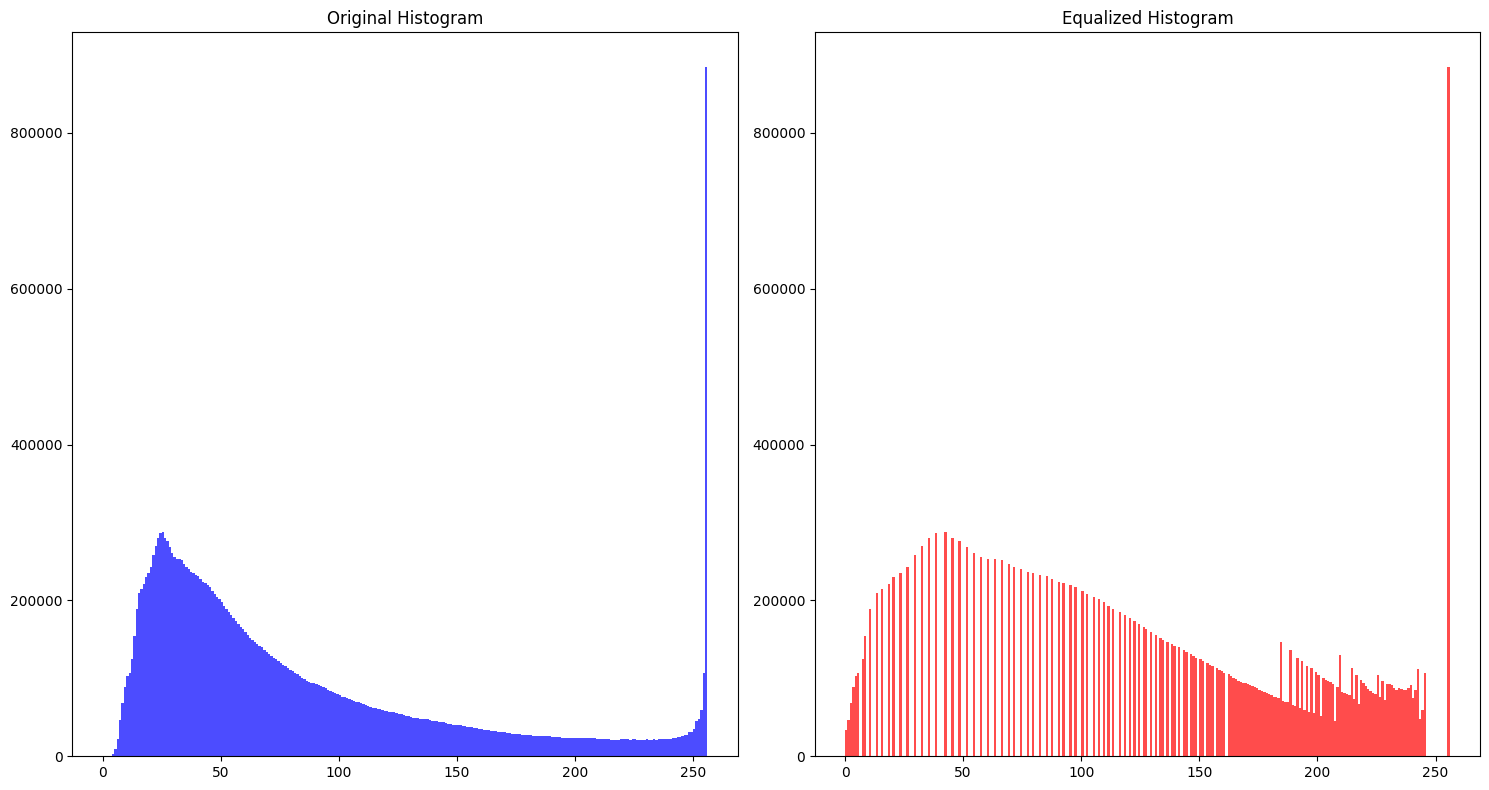

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_data = np.array(data, dtype=np.uint8)

equalized_image = cv2.equalizeHist(image_data)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(equalized_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Equalized Histogram')

plt.tight_layout()
plt.show()

In [4]:
#Contrast Limited Adaptive Histogram Equalization 
def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

def brighten(row, target_mean_brightness=128, max_brightness_adjustment=50):
    current_mean_brightness = np.mean(row)
    brightness_adjustment = target_mean_brightness - current_mean_brightness
    brightness_adjustment = np.clip(brightness_adjustment, -max_brightness_adjustment, max_brightness_adjustment)
    scaling_factor = (current_mean_brightness + brightness_adjustment) / current_mean_brightness
    adjusted_row = row * scaling_factor
    adjusted_row[adjusted_row < 0] = 0
    adjusted_row[adjusted_row > 255] = 255
    return adjusted_row


def apply_gamma_correction(row, gamma=1.8):
    input_shape = row.shape
    row = np.array(row, dtype=np.uint8)
    corrected_row = ((row / 255.0) ** (1 / gamma) * 255).astype(np.uint8)
    corrected_row = corrected_row.reshape(*input_shape) 
    return corrected_row

In [6]:
x_copy = x_train.copy()

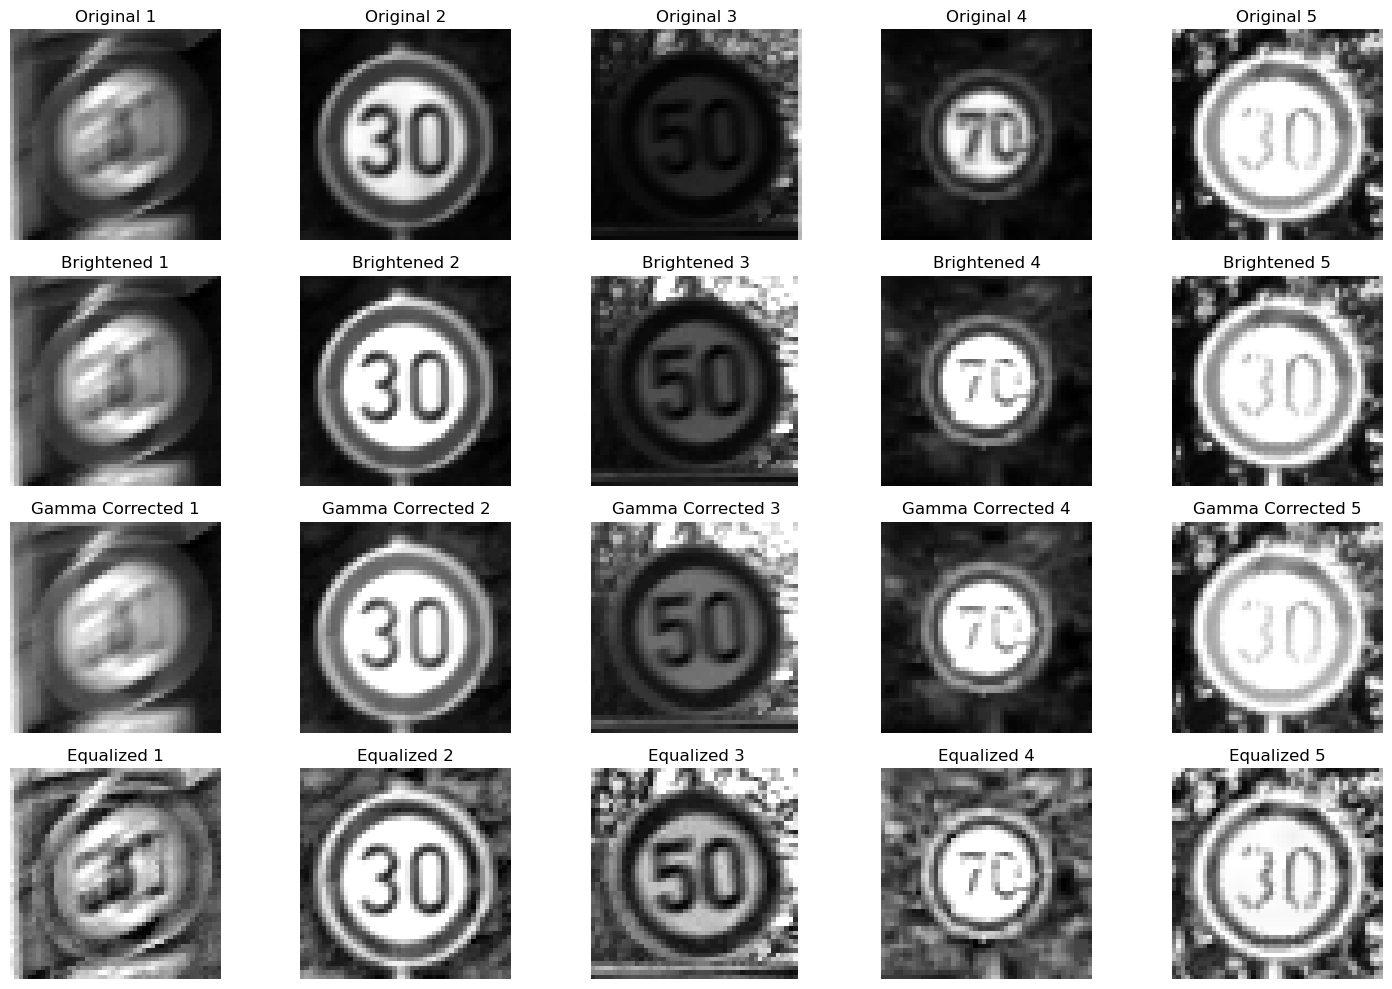

In [5]:
sample_size = 5
sample_indices = x_copy.sample(sample_size).index


plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    plt.subplot(4, sample_size, i + 1)
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    brightened_image = brighten(x_copy.iloc[idx].values)
    plt.subplot(4, sample_size, sample_size + i + 1)
    brightened_image = brightened_image.reshape(48, 48)
    plt.imshow(brightened_image, cmap='gray')
    plt.title(f'Brightened {i+1}')
    plt.axis('off')

    gamma_image = apply_gamma_correction(brightened_image)
    plt.subplot(4, sample_size, 2*sample_size + i + 1)
    plt.imshow(gamma_image, cmap='gray')
    plt.title(f'Gamma Corrected {i+1}')
    plt.axis('off')

    equalized_image = apply_clahe(gamma_image)
    plt.subplot(4, sample_size, 3*sample_size + i + 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [14]:
processed_images = []

sample_size = 5
sample_indices = x_copy.sample(sample_size).index

for i, idx in enumerate(sample_indices):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)

    processed_images.append(equalized_image.flatten())

processed_df_subset = pd.DataFrame(processed_images)
processed_df_subset.shape

(5, 2304)

In [7]:
processed_images = []

for i, idx in enumerate(x_copy.index):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)
    processed_images.append(equalized_image.flatten())

processed_df = pd.DataFrame(processed_images)
processed_df.shape

(9690, 2304)

In [8]:
x_train.shape

(9690, 2304)

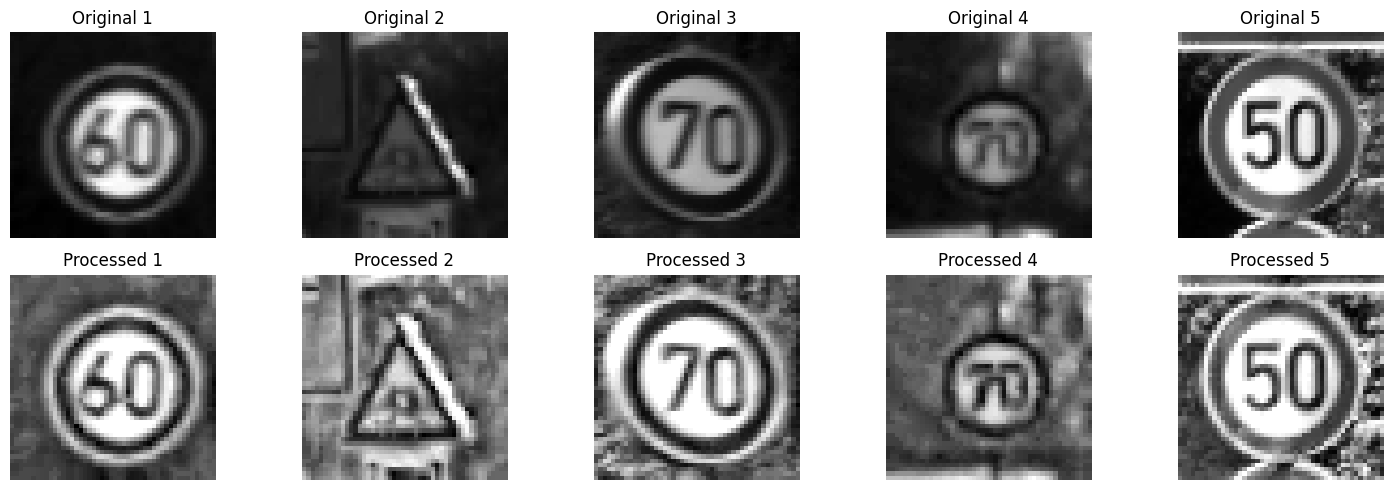

In [15]:
x_train_reset = x_copy.reset_index(drop=True)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    original_image = x_train_reset.iloc[idx].values.reshape(48, 48)
    processed_image = processed_df_subset.iloc[i].values.reshape(48, 48)

    plt.subplot(2, sample_size, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(2, sample_size, sample_size + i + 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Processed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
merged_df.shape

(9690, 2305)

In [11]:
# merged_df.to_csv("merged_df.csv")

In [12]:
# processed_df.to_csv("processed_df.csv")

In [13]:
processed_df.shape

(9690, 2304)

In [14]:
y_train.shape

(9690, 1)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train, X_test, Y_train, Y_test = train_test_split(processed_df, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.49810801513587893
F1 Score: 0.4885696233677467
Confusion Matrix:
 [[ 49 159  23  20  43   0   0   0   0   0]
 [  4 211  72  15  27   0   1   0   1   0]
 [  5  84 315  32  36   0   0   0   1   1]
 [  0  62  66 183  64   0   1   0   2   1]
 [  4 132 136 109 389   2   1   0   0   3]
 [  0   0   2   0   0  47   7   5  22  15]
 [  2  17  39  42  18  10  71   2  26  11]
 [  0   0   0   0   0   1   0  43   3   0]
 [  0   0   0   0   0   2   3   1  99   5]
 [  1  21  11  19   6   3  20  14  24  41]]


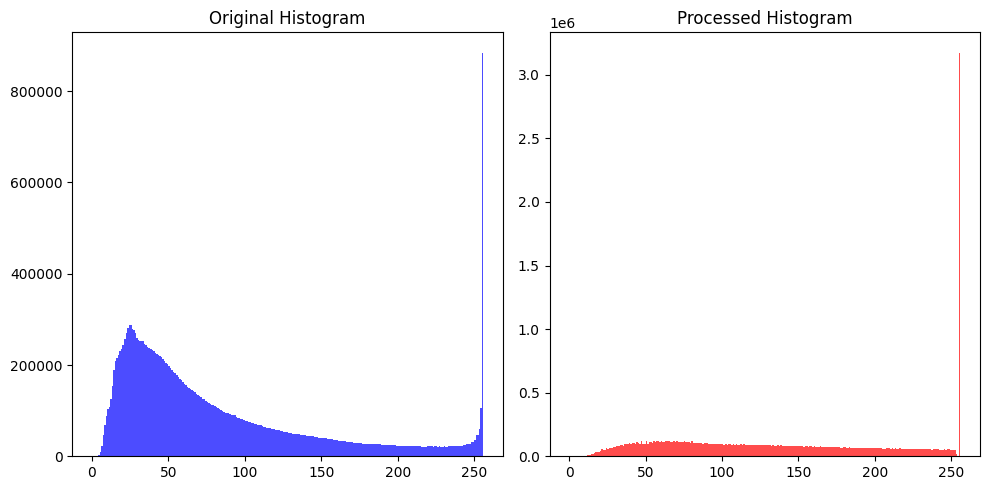

In [19]:
image_data = np.array(data, dtype=np.uint8)

processed_image = apply_clahe(apply_gamma_correction(brighten(image_data)))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [20]:
# Z normalization to preprocessed data
mean=processed_df.mean()
std=processed_df.std()
processed_df_norm=(processed_df-mean)/std

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(processed_df_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_norm, Y_train_norm)

predicted = gnb.predict(X_test_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
accuracy = accuracy_score(predicted, Y_test_norm)
f1 = f1_score(predicted, Y_test_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.49810801513587893
F1 Score: 0.4885696233677467
Confusion Matrix:
 [[ 49 159  23  20  43   0   0   0   0   0]
 [  4 211  72  15  27   0   1   0   1   0]
 [  5  84 315  32  36   0   0   0   1   1]
 [  0  62  66 183  64   0   1   0   2   1]
 [  4 132 136 109 389   2   1   0   0   3]
 [  0   0   2   0   0  47   7   5  22  15]
 [  2  17  39  42  18  10  71   2  26  11]
 [  0   0   0   0   0   1   0  43   3   0]
 [  0   0   0   0   0   2   3   1  99   5]
 [  1  21  11  19   6   3  20  14  24  41]]


In [23]:
# Outlier mining to processed data

from sklearn.ensemble import IsolationForest

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(processed_df)

outlier_indices = processed_df.index[outliers == -1]

x_train_no_outliers = processed_df.drop(outlier_indices)
y_train_no_outliers = y_train.loc[x_train_no_outliers.index]

print(x_train_no_outliers.shape)
y_train_no_outliers.shape

(9593, 2304)


(9593, 1)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train_out, X_test_out, Y_train_out, Y_test_out = train_test_split(x_train_no_outliers, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_out, Y_train_out)

predicted = gnb.predict(X_test_out)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
accuracy = accuracy_score(predicted, Y_test_out)
f1 = f1_score(predicted, Y_test_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5013898540653231
F1 Score: 0.4908434617972536
Confusion Matrix:
 [[ 38 157  30  24  36   0   0   0   1   1]
 [ 11 219  57  11  23   0   1   0   0   2]
 [  4  89 295  38  57   0   0   0   0   0]
 [  2  53  79 165  56   0   2   0   1   0]
 [  6 115 140  86 387   0   2   0   1   2]
 [  0   0   4   0   1  54  10   4  23   7]
 [  1  16  53  77  21   7  74   5  24   7]
 [  0   0   0   0   0   3   0  49   4   0]
 [  0   0   0   1   0   4   4   2 103   2]
 [  0   8  11   6   3   1  24   9   6  59]]


In [26]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5013898540653231
F1 Score: 0.4908434617972536
Confusion Matrix:
 [[ 38 157  30  24  36   0   0   0   1   1]
 [ 11 219  57  11  23   0   1   0   0   2]
 [  4  89 295  38  57   0   0   0   0   0]
 [  2  53  79 165  56   0   2   0   1   0]
 [  6 115 140  86 387   0   2   0   1   2]
 [  0   0   4   0   1  54  10   4  23   7]
 [  1  16  53  77  21   7  74   5  24   7]
 [  0   0   0   0   0   3   0  49   4   0]
 [  0   0   0   1   0   4   4   2 103   2]
 [  0   8  11   6   3   1  24   9   6  59]]


In [29]:
no_out_processed_df_norm.shape

(9593, 2304)

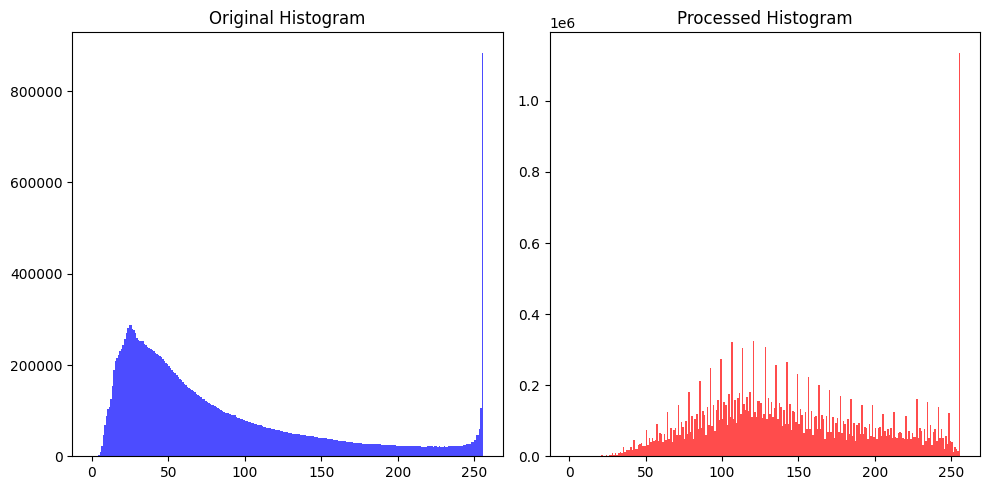

In [30]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [31]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 26

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.47498262682418346
F1 Score: 0.46602304029462394
Confusion Matrix:
 [[ 27 144  34  39  37   0   0   0   0   0]
 [ 18 187  61  13  47   0   0   0   0   2]
 [  2  88 293  31  55   0   1   0   1   0]
 [  2  58  84 156  71   0   2   0   0   0]
 [  9 134 146 118 404   4   2   0   1   1]
 [  0   0   2   0   0  52  16   5  21  11]
 [  2  11  52  46  14   9  73   4  27   6]
 [  0   0   0   0   0   1   0  44   4   0]
 [  0   0   0   0   0   1   4   3  85   3]
 [  0  12   8   8   2   5  14  10   5  46]]


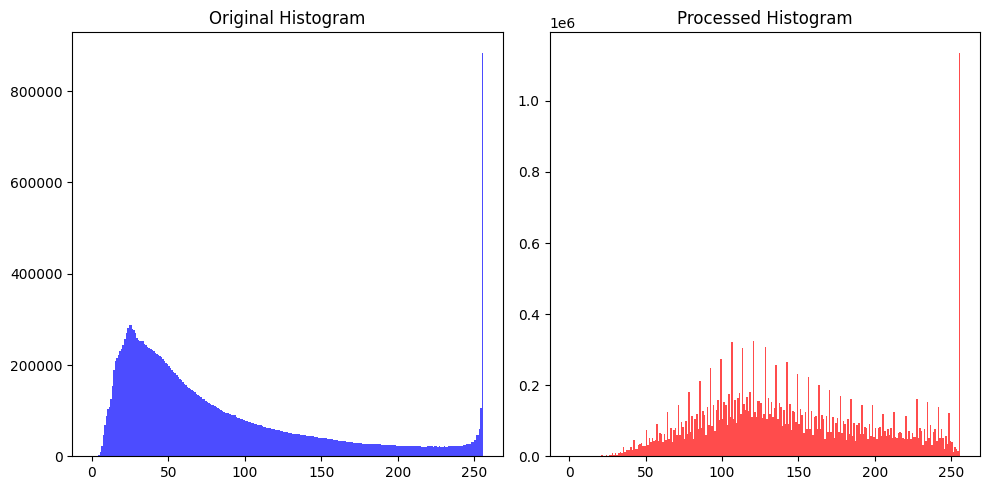

In [34]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

#### Different Naive Bayes model

In [35]:
#raw data 
from sklearn.naive_bayes import MultinomialNB
seed_value=75
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train, Y_train)

predicted = bayesClf.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
bayesPredictions = bayesClf.predict(X_test)
bayesAcc = accuracy_score(Y_test, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.3722050223598211


In [37]:
processed_df
negative_values = (processed_df < 0)

# Use 'any' to check if there are any negative values in each column
negative_in_columns = negative_values.any()

# Print which columns have negative values
print("Columns with negative values:")
print(negative_in_columns)


Columns with negative values:
0       False
1       False
2       False
3       False
4       False
        ...  
2299    False
2300    False
2301    False
2302    False
2303    False
Length: 2304, dtype: bool


In [38]:
Xmin=processed_df.min()
Xmax=processed_df.max()

In [39]:
X = (processed_df - Xmin)/(Xmax - Xmin)

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(processed_df), columns=processed_df.columns)


In [41]:
df_normalized

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.265560,0.236515,0.236515,0.393162,0.456067,0.449153,0.523207,0.658120,0.557940,0.576923,...,0.526971,0.502075,0.268085,0.373444,0.456432,0.610169,0.694561,0.657258,0.547009,0.560166
1,0.439834,0.531120,0.618257,0.576923,0.485356,0.389831,0.489451,0.636752,0.849785,0.786325,...,0.514523,0.531120,0.425532,0.315353,0.161826,0.258475,0.502092,0.770161,0.786325,0.792531
2,0.294606,0.381743,0.439834,0.393162,0.426778,0.461864,0.582278,0.576923,0.236052,0.243590,...,0.556017,0.531120,0.442553,0.365145,0.265560,0.228814,0.368201,0.572581,0.696581,0.792531
3,0.178423,0.265560,0.352697,0.363248,0.518828,0.610169,0.599156,0.405983,0.030043,0.393162,...,0.730290,0.439834,0.378723,0.352697,0.356846,0.288136,0.301255,0.427419,0.636752,0.763485
4,0.352697,0.352697,0.323651,0.273504,0.376569,0.440678,0.582278,0.606838,0.236052,0.153846,...,0.473029,0.410788,0.489362,0.609959,0.630705,0.538136,0.493724,0.229839,0.243590,0.352697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.000000,1.000000,1.000000,1.000000,0.694561,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.265560,0.178423,0.140426,0.174274,0.190871,0.161017,0.175732,0.370968,0.333333,0.381743
9686,0.912863,0.705394,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.406639,0.265560,0.242553,0.286307,0.307054,0.317797,0.297071,0.258065,0.273504,0.265560
9687,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.356846,0.502075,0.417021,0.344398,0.265560,0.411017,0.497908,0.342742,0.517094,0.589212
9688,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.443983,0.149378,0.127660,0.215768,0.473029,0.300847,0.313808,0.342742,0.303419,0.265560


In [42]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-1.257863,-1.404781,-1.427885,-0.719896,-0.509161,-0.504991,-0.220264,0.337407,-0.062304,-0.009235,...,0.072320,-0.061088,-1.049233,-0.625354,-0.227140,0.540123,0.928383,0.691759,0.288208,0.286668
1,-0.571924,-0.217322,0.141484,0.017030,-0.390679,-0.740867,-0.355256,0.252498,1.092180,0.819991,...,0.015454,0.073182,-0.339206,-0.892750,-1.591669,-1.081026,0.015326,1.249464,1.389816,1.335049
2,-1.143540,-0.819414,-0.592025,-0.719896,-0.627642,-0.454446,0.015974,0.014751,-1.335632,-1.329228,...,0.205009,0.073182,-0.262446,-0.663553,-1.111201,-1.217749,-0.619844,0.273481,0.976713,1.335049
3,-1.600832,-1.287707,-0.950251,-0.839861,-0.255272,0.135244,0.083470,-0.664526,-2.150562,-0.736923,...,1.001141,-0.348809,-0.550295,-0.720853,-0.688389,-0.944303,-0.937428,-0.443567,0.701311,1.204001
4,-0.914893,-0.936487,-1.069659,-1.199755,-0.830753,-0.538688,0.015974,0.133624,-1.335632,-1.684611,...,-0.174101,-0.483079,-0.051357,0.463331,0.580046,0.208080,-0.024372,-1.419550,-1.108474,-0.649386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.632879,1.672577,1.710853,1.713674,0.455616,1.685286,1.686509,1.695960,1.686400,1.666140,...,-1.121877,-1.557238,-1.624931,-1.542142,-1.457138,-1.530260,-1.532900,-0.722419,-0.695371,-0.518338
9686,1.289910,0.485119,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.477390,-1.154428,-1.164373,-1.026449,-0.919014,-0.807579,-0.957277,-1.280124,-0.970773,-1.042528
9687,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.704856,-0.061088,-0.377586,-0.759052,-1.111201,-0.377877,-0.004523,-0.861846,0.150507,0.417716
9688,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.306790,-1.691507,-1.682501,-1.351144,-0.150265,-0.885707,-0.877881,-0.861846,-0.833072,-1.042528


In [43]:
X

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.265560,0.236515,0.236515,0.393162,0.456067,0.449153,0.523207,0.658120,0.557940,0.576923,...,0.526971,0.502075,0.268085,0.373444,0.456432,0.610169,0.694561,0.657258,0.547009,0.560166
1,0.439834,0.531120,0.618257,0.576923,0.485356,0.389831,0.489451,0.636752,0.849785,0.786325,...,0.514523,0.531120,0.425532,0.315353,0.161826,0.258475,0.502092,0.770161,0.786325,0.792531
2,0.294606,0.381743,0.439834,0.393162,0.426778,0.461864,0.582278,0.576923,0.236052,0.243590,...,0.556017,0.531120,0.442553,0.365145,0.265560,0.228814,0.368201,0.572581,0.696581,0.792531
3,0.178423,0.265560,0.352697,0.363248,0.518828,0.610169,0.599156,0.405983,0.030043,0.393162,...,0.730290,0.439834,0.378723,0.352697,0.356846,0.288136,0.301255,0.427419,0.636752,0.763485
4,0.352697,0.352697,0.323651,0.273504,0.376569,0.440678,0.582278,0.606838,0.236052,0.153846,...,0.473029,0.410788,0.489362,0.609959,0.630705,0.538136,0.493724,0.229839,0.243590,0.352697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.000000,1.000000,1.000000,1.000000,0.694561,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.265560,0.178423,0.140426,0.174274,0.190871,0.161017,0.175732,0.370968,0.333333,0.381743
9686,0.912863,0.705394,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.406639,0.265560,0.242553,0.286307,0.307054,0.317797,0.297071,0.258065,0.273504,0.265560
9687,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.356846,0.502075,0.417021,0.344398,0.265560,0.411017,0.497908,0.342742,0.517094,0.589212
9688,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.443983,0.149378,0.127660,0.215768,0.473029,0.300847,0.313808,0.342742,0.303419,0.265560


In [44]:
#processed data
X_train, X_test, Y_train, Y_test = train_test_split(df_normalized, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train, Y_train)

predicted = bayesClf.predict(X_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
bayesPredictions = bayesClf.predict(X_test)
bayesAcc = accuracy_score(Y_test, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4681802545579635


In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_pro = pd.DataFrame(scaler.fit_transform(processed_df_norm), columns=processed_df_norm.columns)

In [47]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_pro, y_train, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [48]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4681802545579635


In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_no_out = pd.DataFrame(scaler.fit_transform(x_train_no_outliers), columns=x_train_no_outliers.columns)

In [50]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_no_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [51]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4624739402362752


In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_normalized_pro_norm = pd.DataFrame(scaler.fit_transform(no_out_processed_df_norm), columns=no_out_processed_df_norm.columns)

In [53]:
#processed data
X_train_pro, X_test_pro, Y_train_pro, Y_test_pro = train_test_split(df_normalized_pro_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

bayesClf = MultinomialNB()
bayesClf.fit(X_train_pro, Y_train_pro)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [54]:
bayesPredictions = bayesClf.predict(X_test_pro)
bayesAcc = accuracy_score(Y_test_pro, bayesPredictions)
print("The accuracy:", bayesAcc)

The accuracy: 0.4624739402362752


In [55]:
from sklearn.naive_bayes import ComplementNB
complementClf = ComplementNB()
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=22)

complementClf.fit(X_train, Y_train)


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ComplementNB()

In [56]:
complementPredictions = complementClf.predict(X_test)
complementAcc = accuracy_score(Y_test, complementPredictions)
print("The accuracy:", complementAcc)

The accuracy: 0.36945304437564497


In [57]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,96.0,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,98.0,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,112.0,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,100.0,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,35.0,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,37.0,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,41.0,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,38.0,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0


In [58]:
y_train

,0
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [59]:
from sklearn.naive_bayes import CategoricalNB
categoricalClf = CategoricalNB()
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=22)

categoricalClf.fit(X_train, Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CategoricalNB()

In [60]:
categoricalPredictions = categoricalClf.predict(X_test)
categoricalAcc = accuracy_score(Y_test, categoricalPredictions)
print("The accuracy:", categoricalAcc)

The accuracy: 0.37014103887168903


In [61]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
255,217.0,165.0,174.0,193.0,218.0,245.0,255.0,255.0,255.0,255.0,...,73.0,96.0,123.0,88.0,66.0,58.0,61.0,65.0,66.0,67.0
3764,20.0,27.0,45.0,49.0,38.0,37.0,33.0,58.0,95.0,115.0,...,23.0,22.0,22.0,21.0,19.0,18.0,19.0,19.0,20.0,21.0
7582,47.0,50.0,45.0,42.0,43.0,45.0,42.0,40.0,40.0,37.0,...,54.0,53.0,50.0,50.0,49.0,49.0,49.0,48.0,41.0,35.0
848,60.0,56.0,49.0,45.0,46.0,52.0,54.0,55.0,57.0,57.0,...,64.0,65.0,66.0,68.0,69.0,69.0,69.0,67.0,66.0,65.0
7348,36.0,40.0,43.0,33.0,29.0,31.0,33.0,36.0,37.0,37.0,...,38.0,35.0,32.0,32.0,36.0,40.0,38.0,29.0,33.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,75.0,84.0,66.0,56.0,42.0,40.0,39.0,38.0,44.0,96.0,...,160.0,174.0,161.0,141.0,118.0,85.0,68.0,62.0,51.0,46.0
1998,40.0,58.0,70.0,64.0,56.0,53.0,50.0,59.0,63.0,39.0,...,213.0,207.0,214.0,219.0,214.0,213.0,215.0,220.0,232.0,236.0
1952,90.0,98.0,111.0,96.0,98.0,129.0,160.0,191.0,217.0,238.0,...,85.0,86.0,70.0,66.0,63.0,60.0,58.0,56.0,65.0,70.0
8461,32.0,29.0,25.0,24.0,24.0,28.0,31.0,31.0,31.0,31.0,...,27.0,27.0,26.0,23.0,22.0,23.0,22.0,22.0,21.0,20.0


In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_processed_df_norm = pd.DataFrame(scaler.fit_transform(processed_df_norm), columns=processed_df_norm.columns)

In [63]:
df_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.265560,0.236515,0.236515,0.393162,0.456067,0.449153,0.523207,0.658120,0.557940,0.576923,...,0.526971,0.502075,0.268085,0.373444,0.456432,0.610169,0.694561,0.657258,0.547009,0.560166
1,0.439834,0.531120,0.618257,0.576923,0.485356,0.389831,0.489451,0.636752,0.849785,0.786325,...,0.514523,0.531120,0.425532,0.315353,0.161826,0.258475,0.502092,0.770161,0.786325,0.792531
2,0.294606,0.381743,0.439834,0.393162,0.426778,0.461864,0.582278,0.576923,0.236052,0.243590,...,0.556017,0.531120,0.442553,0.365145,0.265560,0.228814,0.368201,0.572581,0.696581,0.792531
3,0.178423,0.265560,0.352697,0.363248,0.518828,0.610169,0.599156,0.405983,0.030043,0.393162,...,0.730290,0.439834,0.378723,0.352697,0.356846,0.288136,0.301255,0.427419,0.636752,0.763485
4,0.352697,0.352697,0.323651,0.273504,0.376569,0.440678,0.582278,0.606838,0.236052,0.153846,...,0.473029,0.410788,0.489362,0.609959,0.630705,0.538136,0.493724,0.229839,0.243590,0.352697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.000000,1.000000,1.000000,1.000000,0.694561,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.265560,0.178423,0.140426,0.174274,0.190871,0.161017,0.175732,0.370968,0.333333,0.381743
9686,0.912863,0.705394,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.406639,0.265560,0.242553,0.286307,0.307054,0.317797,0.297071,0.258065,0.273504,0.265560
9687,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.356846,0.502075,0.417021,0.344398,0.265560,0.411017,0.497908,0.342742,0.517094,0.589212
9688,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.443983,0.149378,0.127660,0.215768,0.473029,0.300847,0.313808,0.342742,0.303419,0.265560


In [64]:
y_train

,0
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [65]:
categoricalClf = CategoricalNB(min_categories=df_processed_df_norm.nunique())
X_train, X_test, Y_train, Y_test = train_test_split(df_processed_df_norm, y_train, test_size=0.3)

categoricalClf.fit(X_train, Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CategoricalNB(min_categories=0        35
1        35
2        35
3        34
4       227
       ... 
2299    150
2300    227
2301     35
2302     34
2303     35
Length: 2304, dtype: int64)

In [66]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
9249,0.352697,0.294606,0.352697,0.423077,0.485356,0.529661,0.523207,0.525641,0.429185,0.393162,...,0.240664,0.265560,0.327660,0.423237,0.485477,0.449153,0.430962,0.516129,0.487179,0.473029
1539,0.618257,0.502075,0.352697,0.333333,0.338912,0.347458,0.371308,0.333333,0.433476,0.487179,...,0.497925,0.502075,0.493617,0.539419,0.547718,0.483051,0.372385,0.399194,0.393162,0.502075
6069,0.352697,0.352697,0.352697,0.393162,0.338912,0.398305,0.582278,0.487179,0.403433,0.423077,...,0.456432,0.473029,0.442553,0.423237,0.414938,0.398305,0.447699,0.487903,0.457265,0.502075
3272,0.265560,0.294606,0.294606,0.303419,0.410042,0.470339,0.476793,0.444444,0.450644,0.423077,...,1.000000,1.000000,0.859574,0.626556,0.398340,0.377119,0.439331,0.516129,0.517094,0.589212
8709,0.589212,0.618257,0.618257,0.576923,0.581590,0.572034,0.599156,0.615385,0.665236,0.606838,...,0.721992,0.589212,0.523404,0.609959,0.543568,0.580508,0.594142,0.572581,0.517094,0.560166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,0.941909,0.941909,0.941909,0.910256,0.820084,0.711864,0.582278,0.367521,0.489270,0.636752,...,0.917012,0.912863,0.885106,0.863071,0.763485,0.588983,0.665272,0.887097,0.786325,0.763485
7005,0.941909,0.883817,0.763485,0.636752,0.476987,0.368644,0.582278,0.786325,0.888412,0.940171,...,0.207469,0.381743,0.697872,0.871369,0.514523,0.411017,0.380753,0.516129,0.636752,0.410788
4302,0.792531,0.941909,0.792531,0.333333,0.196653,0.211864,0.236287,0.252137,0.274678,0.423077,...,0.468880,0.560166,0.455319,0.323651,0.232365,0.186441,0.234310,0.399194,0.636752,0.502075
2114,0.792531,0.647303,0.676349,0.816239,0.807531,0.521186,0.611814,0.576923,0.351931,0.183761,...,0.340249,0.560166,0.570213,0.481328,0.439834,0.512712,0.585774,0.544355,0.423077,0.439834


In [67]:
categoricalPredictions = categoricalClf.predict(X_test)
categoricalAcc = accuracy_score(Y_test, categoricalPredictions)
print("The accuracy:", categoricalAcc)


The accuracy: 0.3106295149638803


#### PCA

In [68]:
y_train=y_train.rename(columns={'0':'label'})

In [69]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [70]:
merged_df = pd.concat([x_train, y_train], axis=1)



In [71]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0,0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0,0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0,0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0,0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0,9
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0,9
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0,9
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0,9


In [73]:
from sklearn.decomposition import PCA

df = merged_df
target_column = 'label'
features = df.drop(target_column, axis=1)
target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(features)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca)

Transformed DataFrame:
              PC1          PC2          PC3          PC4         PC5  \
0     1833.678654  -327.432280  -247.743190  -608.483725 -348.793586   
1     1859.007019  -349.977157  -192.222284  -595.379147 -443.962325   
2     1764.509881  -388.614024  -133.034248  -686.073427 -473.539396   
3     1676.632914  -400.702911  -100.745308  -732.746033 -495.178381   
4     1902.532764  -338.990792   -62.149332  -692.201419 -284.736494   
...           ...          ...          ...          ...         ...   
9685   987.795453  1450.984446 -1503.450258 -1658.624172 -413.021046   
9686  1017.324304  1511.469231 -1452.548502 -1577.032597 -653.548399   
9687   985.864551  1719.211492 -1749.455042 -1361.267595   28.937440   
9688  1180.694571  1818.178520 -1816.040253 -1798.650931 -378.454307   
9689   564.088760  1545.222780  -854.697719 -1612.762414 -809.463745   

             PC6         PC7          PC8         PC9        PC10        PC11  \
0     651.336688  303.656130   

In [74]:
df_pca_top5 = df_pca.iloc[:, :5]
df_pca_top10 = df_pca.iloc[:, :10]
df_pca_top20 = df_pca.iloc[:, :20]


In [75]:
target

0       0
1       0
2       0
3       0
4       0
       ..
9685    9
9686    9
9687    9
9688    9
9689    9
Name: label, Length: 9690, dtype: int64

In [76]:
df_pca_top5

,PC1,PC2,PC3,PC4,PC5
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793586
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962325
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539396
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494
...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021046
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548399
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454307


In [77]:
df_pca_top10

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793586,651.336688,303.656130,-10.808827,-408.737267,-79.937101
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962325,680.431307,207.689759,5.860395,-543.226952,-130.359090
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539396,771.513299,156.383294,138.760409,-385.598243,-246.734120
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381,677.334753,92.548687,214.775708,-312.437514,-322.254992
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494,617.853672,387.861210,-36.146828,-536.267132,51.230825
...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021046,-330.777650,181.004827,-1054.855439,903.460501,-37.743745
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548399,-414.617206,-148.818068,-821.675975,789.395412,71.777307
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440,290.977605,280.584686,-954.103331,352.117398,-86.530393
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454307,-145.034629,361.183087,-795.636718,375.357591,-119.636581


In [78]:
df_pca_top20

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793586,651.336688,303.656130,-10.808827,-408.737267,-79.937101,400.216430,-535.057155,92.642024,-329.381437,-154.889227,-113.273403,158.960720,191.135535,-140.617456,-72.151789
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962325,680.431307,207.689759,5.860395,-543.226952,-130.359090,357.892276,-594.533268,123.229261,-213.341638,-83.742259,-148.796594,237.459660,179.171303,82.660922,-8.777002
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539396,771.513299,156.383294,138.760409,-385.598243,-246.734120,345.025003,-392.811341,60.543482,-147.893621,-172.005424,-89.628543,153.768731,298.532380,210.598494,-21.100332
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178381,677.334753,92.548687,214.775708,-312.437514,-322.254992,328.955699,-277.286328,61.234071,-119.369249,-247.394697,-44.507883,92.348627,280.020357,249.754070,-254.969450
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736494,617.853672,387.861210,-36.146828,-536.267132,51.230825,347.808384,-250.270198,206.622818,-249.672776,-64.480322,-206.108153,115.063875,211.785633,-12.679141,330.113920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624172,-413.021046,-330.777650,181.004827,-1054.855439,903.460501,-37.743745,-247.926321,49.277752,200.353549,-506.980831,40.265807,-147.596574,358.043306,-117.167914,-184.374633,288.143187
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548399,-414.617206,-148.818068,-821.675975,789.395412,71.777307,-364.865317,-27.950427,618.334877,-114.263886,-39.065323,-201.506887,185.015413,0.426628,90.035079,87.168969
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937440,290.977605,280.584686,-954.103331,352.117398,-86.530393,68.016478,18.488728,540.978414,229.527974,-90.164644,-477.296052,246.619198,406.784176,231.006733,283.391709
9688,1180.694571,1818.178520,-1816.040253,-1798.650931,-378.454307,-145.034629,361.183087,-795.636718,375.357591,-119.636581,179.098825,-82.410124,784.773861,21.767730,-34.736515,-390.642423,413.377374,545.180140,247.797256,57.648020


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np

def train_and_predict_with_naive_bayes(df1, df2,seed_value=20):
    X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(df1, df2, test_size=0.3,random_state=seed_value)
    
    gnb = GaussianNB()
    gnb.fit(X_train_5, Y_train_5)
    
    predicted = gnb.predict(X_test_5)
    accuracy = accuracy_score(Y_test_5,predicted )
    f1 = f1_score(predicted, Y_test_5, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test_5)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted


def train_and_predict_with_naive_bayes_search(df1, df2):
    X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(df1, df2, test_size=0.3)
    param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


    gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    gnb.fit(X_train_5, Y_train_5)
    
    predicted = gnb.predict(X_test_5)
    accuracy = accuracy_score(predicted, Y_test_5)
    f1 = f1_score(predicted, Y_test_5, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test_5)
    print(gnb.best_estimator_)

    print("Accuracy:", accuracy)
    print(precision_score(predicted, Y_test_5,average="weighted"), ": is the precision score")
    print(recall_score(predicted, Y_test_5,average="weighted"), ": is the recall score")
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted


In [80]:
train_and_predict_with_naive_bayes(df_pca_top5, y_train,seed_value=20)

Accuracy: 0.3402132782937736
F1 Score: 0.36797210679919823
Confusion Matrix:
 [[  4   4   5   2   1   0   0   0   0   0]
 [ 28 283 107  39  43   2   4   4  46   6]
 [ 12 155 191  19  89  18   0  18  13   5]
 [  0  23  60  95  40   2  23  11   8   8]
 [  7 199 298 245 393  40  88  32  81  44]
 [  0   0   0   1   0   0   1   1   1   0]
 [  0   3   4   2   6   0   3   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0]
 [  0  23   8   9   7   0   3   5  20   8]
 [  0   4   0   1   0   0   0   0   0   0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 2, 2, ..., 1, 4, 2])

In [81]:
train_and_predict_with_naive_bayes_search(df_pca_top5, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

GaussianNB()
Accuracy: 0.31922944616443066
0.46290872609869294 : is the precision score
0.31922944616443066 : is the recall score
F1 Score: 0.3419819890420831
Confusion Matrix:
 [[  5   4   2   0   0   0   0   0   0   0]
 [ 26 252 115  30  54   1   0   4  36   4]
 [ 17 160 163  13  93   8   0   9  19   3]
 [  0  19  57 108  51   0  15  14   9  15]
 [ 11 232 324 262 378  39  80  33  73  48]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   1   0   1   0]
 [  0   5   5   1   0   0   1   0   3   0]
 [  0  24  10   6   7   1   0   4  19   5]
 [  0   9   0   6   0   1   1   0   6   2]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([4, 1, 3, ..., 1, 4, 4])

In [83]:
#Unprocessed data PCA applied top 5 seed 22

seed_value = 22

X_train_5, X_test_5, Y_train_5, Y_test_5= train_test_split(df_pca_top5, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5, Y_train_5)

predicted = gnb.predict(X_test_5)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
accuracy = accuracy_score(predicted, Y_test_5)
f1 = f1_score(predicted, Y_test_5, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.34055727554179566
F1 Score: 0.362623787897526
Confusion Matrix:
 [[ 10   0   2   0   0   0   0   0   0   0]
 [ 35 274 129  49  37   2   2   6  44   5]
 [ 10 159 192  20  93  11   0  17  20   9]
 [  2  16  51 101  48   0  18  13   5  11]
 [  8 197 269 223 381  49  67  25  75  48]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0  11  10  10  18   0  12   0   3   0]
 [  0   3   1   1   0   0   2   1   2   0]
 [  0  19   8   5   4   1   0   3  18   3]
 [  0   7   2  11   2   2   3   0  11   1]]


In [85]:
#Unprocessed data PCA applied top 10 seed 24
seed_value = 24

X_train_10, X_test_10, Y_train_10, Y_test_10= train_test_split(df_pca_top10, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10, Y_train_10)

predicted = gnb.predict(X_test_10)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
accuracy = accuracy_score(predicted, Y_test_10)
f1 = f1_score(predicted, Y_test_10, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.38837289301685585
F1 Score: 0.4021382359007353
Confusion Matrix:
 [[ 11   7   6   5   1   0   0   1   1   0]
 [ 25 297 120  44  54   2   0  10  16  11]
 [  9 110 161  22  86   1   0   1   2   6]
 [  1  17  52  89  50   0   4   3   0   0]
 [ 17 194 299 237 397   2   6   1   2  10]
 [  0   4   7   2   2  35  37  10  42  14]
 [  0  18  22  22  12   5  54   9  33   2]
 [  0   1  11   1   0   0   1  29  13   8]
 [  0  14   2   5   1   4   0   5  45   3]
 [  0   5   1   1   0   1  11   4  10  11]]


In [87]:
#Unprocessed data PCA applied top 20 seed 22
seed_value = 24

X_train_20, X_test_20, Y_train_20, Y_test_20= train_test_split(df_pca_top20, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20, Y_train_20)

predicted = gnb.predict(X_test_20)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
accuracy = accuracy_score(predicted, Y_test_20)
f1 = f1_score(predicted, Y_test_20, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.35294117647058826
F1 Score: 0.34794717819775534
Confusion Matrix:
 [[ 10  11   7   0   0   0   0   0   1   1]
 [ 23 301 123  71  62   1   1  10   4  10]
 [  6 103 166  12  69   0   0   0   2   2]
 [  6  40  62  78  66   0   1   1   0   2]
 [ 17 146 232 131 259   0   2   0   0   5]
 [  0   0   1   0   1  24  14   5  24   7]
 [  1  62  85 133 145  13  82  10  40  11]
 [  0   0   4   0   0   6   3  34  27  11]
 [  0   0   0   2   0   4   0   9  60   4]
 [  0   4   1   1   1   2  10   4   6  12]]


In [89]:
processed_df.shape

(9690, 2304)

In [90]:
y_train.shape


(9690, 1)

In [91]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [92]:
df = processed_df
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro)

Transformed DataFrame:
              PC1          PC2         PC3         PC4          PC5  \
0      128.221778  -706.332278 -434.178885  205.173275    46.765405   
1      138.324766  -895.278595 -333.466499  347.112205    35.921164   
2        0.626881 -1168.954100 -225.181761  213.424311   198.453758   
3      -47.346033 -1153.965453 -162.091387  113.552010   206.306060   
4      187.302379  -453.735141 -166.849325  152.422833   101.008933   
...           ...          ...         ...         ...          ...   
9685   925.718042  -506.008785  -24.098366  507.379465 -1293.114104   
9686  1007.168660  -674.566318  149.356647  397.504500 -1230.778110   
9687  1115.754285  -520.341562  -60.730141  363.948576 -1586.580321   
9688  1162.896565  -649.157461  168.029939  383.407298 -1571.945976   
9689   931.024978  -623.433659  -46.379564  457.685089  -805.435305   

              PC6         PC7         PC8         PC9        PC10        PC11  \
0      298.952721  -10.697398  493.739391  

In [93]:
df_pca_top5_pro = df_pca_pro.iloc[:, :5]
df_pca_top10_pro = df_pca_pro.iloc[:, :10]
df_pca_top20_pro = df_pca_pro.iloc[:, :20]

In [94]:
#processed data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro, X_test_5_pro, Y_train_5_pro, Y_test_5_pro= train_test_split(df_pca_top5_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro, Y_train_5_pro)

predicted = gnb.predict(X_test_5_pro)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [95]:
accuracy = accuracy_score(predicted, Y_test_5_pro)
f1 = f1_score(predicted, Y_test_5_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36188510491916065
F1 Score: 0.3628963943497866
Confusion Matrix:
 [[  4   3   3   4   0   0   0   0   0   0]
 [ 46 326 148  44  51   1   1   1  11   9]
 [ 11 154 194  30 134   0   0   2   8   1]
 [  2  35  63 124  56   0   2   3   2   2]
 [  1 101 138 167 251   7   5   2   7   1]
 [  0   5   5   5   7  14  12   6   6   9]
 [  2  21  50  40  44   9  46   5  26  15]
 [  0   7  20   1   3   3   1   1   3   8]
 [  6  26  34   0  47  32  14  35  79  27]
 [  0   6   4   2   3   4  23   7  16  13]]


In [96]:
#processed data PCA applied top 10 seed 24
seed_value = 24

X_train_10_pro, X_test_10_pro, Y_train_10_pro, Y_test_10_pro= train_test_split(df_pca_top10_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro, Y_train_10_pro)

predicted = gnb.predict(X_test_10_pro)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [97]:
accuracy = accuracy_score(predicted, Y_test_10_pro)
f1 = f1_score(predicted, Y_test_10_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.42896456828345375
F1 Score: 0.43093473736671023
Confusion Matrix:
 [[ 10   7   4   1   5   0   0   0   0   0]
 [ 29 292  97  35  47   0   2   0   0   2]
 [ 10 206 244  68 104   0   1   0   0   1]
 [  2  19  59 136  62   0   0   2   0   2]
 [ 10 130 249 157 379   1   3   3   5   4]
 [  0   4   3   4   1  24  31  11  27  12]
 [  0   4  18  22   3   7  54   5  19   7]
 [  0   0   2   0   0   9   3  30  32  13]
 [  0   0   0   2   0   6   6  14  65  11]
 [  2   5   5   3   2   3  13   8  16  13]]


In [98]:
#processed data PCA applied top 20 seed 25
seed_value = 25

X_train_20_pro, X_test_20_pro, Y_train_20_pro, Y_test_20_pro= train_test_split(df_pca_top20_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro, Y_train_20_pro)

predicted = gnb.predict(X_test_20_pro)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
accuracy = accuracy_score(predicted, Y_test_20_pro)
f1 = f1_score(predicted, Y_test_20_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5514275885792914
F1 Score: 0.5516913954349295
Confusion Matrix:
 [[ 15  13   2   1   8   0   0   0   0   0]
 [ 33 359 103  32  92   0   1   1   1   7]
 [  7 169 382  94  42   1   1   0   2   6]
 [  1   8  75 215  11   0   0   0   0   1]
 [ 16 125  71  48 433   1   0   2   1   0]
 [  0   0   0   0   0  34  16  16  26  14]
 [  0   2  19  21   7  18  49   4  17  15]
 [  0   0   2   3   0   7   3  23  24   8]
 [  0   2   1   0   1   6   8   8  71  12]
 [  0   6   4   3   2   3  26   8  16  22]]


In [101]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,-1.257863,-1.404781,-1.427885,-0.719896,-0.509161,-0.504991,-0.220264,0.337407,-0.062304,-0.009235,...,0.072320,-0.061088,-1.049233,-0.625354,-0.227140,0.540123,0.928383,0.691759,0.288208,0.286668
1,-0.571924,-0.217322,0.141484,0.017030,-0.390679,-0.740867,-0.355256,0.252498,1.092180,0.819991,...,0.015454,0.073182,-0.339206,-0.892750,-1.591669,-1.081026,0.015326,1.249464,1.389816,1.335049
2,-1.143540,-0.819414,-0.592025,-0.719896,-0.627642,-0.454446,0.015974,0.014751,-1.335632,-1.329228,...,0.205009,0.073182,-0.262446,-0.663553,-1.111201,-1.217749,-0.619844,0.273481,0.976713,1.335049
3,-1.600832,-1.287707,-0.950251,-0.839861,-0.255272,0.135244,0.083470,-0.664526,-2.150562,-0.736923,...,1.001141,-0.348809,-0.550295,-0.720853,-0.688389,-0.944303,-0.937428,-0.443567,0.701311,1.204001
4,-0.914893,-0.936487,-1.069659,-1.199755,-0.830753,-0.538688,0.015974,0.133624,-1.335632,-1.684611,...,-0.174101,-0.483079,-0.051357,0.463331,0.580046,0.208080,-0.024372,-1.419550,-1.108474,-0.649386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,1.632879,1.672577,1.710853,1.713674,0.455616,1.685286,1.686509,1.695960,1.686400,1.666140,...,-1.121877,-1.557238,-1.624931,-1.542142,-1.457138,-1.530260,-1.532900,-0.722419,-0.695371,-0.518338
9686,1.289910,0.485119,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.477390,-1.154428,-1.164373,-1.026449,-0.919014,-0.807579,-0.957277,-1.280124,-0.970773,-1.042528
9687,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.704856,-0.061088,-0.377586,-0.759052,-1.111201,-0.377877,-0.004523,-0.861846,0.150507,0.417716
9688,1.632879,1.672577,1.710853,1.713674,1.691208,1.685286,1.686509,1.695960,1.686400,1.666140,...,-0.306790,-1.691507,-1.682501,-1.351144,-0.150265,-0.885707,-0.877881,-0.861846,-0.833072,-1.042528


In [102]:

df = processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro_norm)

Transformed DataFrame:
            PC1        PC2       PC3       PC4        PC5        PC6  \
0      1.436365 -11.698274 -7.548887  3.794434   0.578770  -5.659716   
1      1.714059 -15.039679 -5.488735  6.608333  -0.011626  -7.489398   
2     -0.737579 -19.657770 -4.319805  5.580494   3.322611  -9.410763   
3     -1.522325 -19.765228 -3.681409  3.832997   3.746609  -8.295624   
4      2.819687  -8.230110 -2.376866  2.908517   1.453484  -6.604795   
...         ...        ...       ...       ...        ...        ...   
9685  14.980591 -10.731423 -2.319994  1.175649 -26.277333 -19.364832   
9686  16.474855 -13.552572  1.176829 -0.344204 -24.779712 -19.960559   
9687  17.720839 -10.565743 -3.549177 -2.831734 -29.539074 -14.508406   
9688  18.576688 -13.439481  0.903588 -1.891678 -29.970859 -21.033225   
9689  15.610222 -12.459700 -1.597683  2.994655 -17.531612 -21.608015   

            PC7        PC8       PC9      PC10      PC11      PC12       PC13  \
0      3.817799   7.614610  7.0

In [103]:
df_pca_top5_norm = df_pca_pro_norm.iloc[:, :5]
df_pca_top1_norm = df_pca_pro_norm.iloc[:, :10]
df_pca_top20_norm= df_pca_pro_norm.iloc[:, :20]


In [104]:
#processed normalized data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro_norm, X_test_5_pro_norm, Y_train_5_pro_norm, Y_test_5_pro_norm= train_test_split(df_pca_top5_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro_norm, Y_train_5_pro_norm)

predicted = gnb.predict(X_test_5_pro_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
accuracy = accuracy_score(predicted, Y_test_5_pro_norm)
f1 = f1_score(predicted, Y_test_5_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36016511867905054
F1 Score: 0.35935752944772675
Confusion Matrix:
 [[  6   4   3   4   0   0   0   0   0   0]
 [ 41 331 146  41  50   2   7   2  18  11]
 [ 14 168 222  40 154   4   0   4   9   1]
 [  2  30  61 112  54   1   2   4   2   3]
 [  1  85 108 174 241   9   8   2   7   2]
 [  0   9  14   8  15  19  17  13  23  14]
 [  2  17  53  36  33   5  42   5  19  14]
 [  0   6   8   0   8   4   3   2   5   5]
 [  6  30  41   0  41  24   7  25  60  23]
 [  0   4   3   2   0   2  18   5  15  12]]


In [106]:
#processed normalized data PCA applied top 10 seed 24
seed_value =20

X_train_10_pro_norm, X_test_10_pro_norm, Y_train_10_pro_norm, Y_test_10_pro_norm= train_test_split(df_pca_top1_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro_norm, Y_train_10_pro_norm)

predicted = gnb.predict(X_test_10_pro_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
accuracy = accuracy_score(predicted, Y_test_10_pro_norm)
f1 = f1_score(predicted, Y_test_10_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4224286205710354
F1 Score: 0.42711878074290566
Confusion Matrix:
 [[  7  12   8   4   5   0   0   0   0   0]
 [ 23 286  98  36  58   1   2   0   6   7]
 [ 13 204 254  45  81   0   1   1   3   6]
 [  1  20  45 110  45   0   4   1   2   0]
 [  8 145 238 185 370   6   3   1   4   1]
 [  0   6   3   0   1  27  20   7  16   7]
 [  0  15  21  27  14  10  61   7  19  15]
 [  0   0   3   1   0   8   4  31  32  10]
 [  0   4   1   1   0   9   8  12  73  16]
 [  0   2   3   4   5   1  19  11  14   9]]


In [108]:
#processed normalized data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro_norm, X_test_20_pro_norm, Y_train_20_pro_norm, Y_test_20_pro_norm= train_test_split(df_pca_top20_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro_norm, Y_train_20_pro_norm)

predicted = gnb.predict(X_test_20_pro_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
accuracy = accuracy_score(predicted, Y_test_20_pro_norm)
f1 = f1_score(predicted, Y_test_20_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4908840729274166
F1 Score: 0.4908164204302908
Confusion Matrix:
 [[ 15  12   6   3   9   0   0   1   0   2]
 [ 24 330 125  49  66   0   1   1   1   6]
 [ 18 189 310  65  92   0   0   1   1   5]
 [  4  23  66 188  28   0   0   0   0   1]
 [ 11 122 129  85 395   2   0   2   1   2]
 [  0   0   0   0   0  34  22  16  31  11]
 [  0   3  16  22   5  17  45   6  20  16]
 [  0   0   2   1   0   8   8  21  22  10]
 [  0   1   1   0   0   5   5   7  66   9]
 [  0   4   4   4   1   4  23   7  16  23]]


In [70]:
x_train_no_outliers

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78,71,71,113,125,125,-114,-81,-104,-100,...,-115,-121,83,104,124,-93,-74,-86,-107,-107
1,120,-114,-93,-100,-124,111,-122,-86,-36,-51,...,-118,-114,120,90,53,80,-120,-58,-51,-51
2,85,106,120,113,118,-128,-100,-100,77,78,...,-108,-114,124,102,78,73,104,-107,-72,-51
3,57,78,99,106,-116,-93,-96,116,29,113,...,-66,120,109,99,100,87,88,113,-86,-58
4,99,99,92,85,106,123,-100,-93,77,57,...,-128,113,-121,-95,-90,-110,-122,64,78,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,-1,-1,-1,-1,-74,-1,-1,-1,-1,-1,...,78,57,53,56,60,57,58,99,99,106
9686,-22,-72,-1,-1,-1,-1,-1,-1,-1,-1,...,112,78,77,83,88,94,87,71,85,78
9687,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,100,-121,118,97,78,116,-121,92,-114,-100
9688,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,121,50,50,66,-128,90,91,92,92,78


In [71]:
no_out_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.038875,0.955074,0.943230,1.440357,1.500832,1.492043,-1.259604,-0.899387,-1.155317,-1.034003,...,-1.363331,-1.334650,0.791198,1.009881,1.238887,-1.133158,-0.903264,-0.944822,-1.201934,-1.247726
1,1.538203,-1.215279,-0.952491,-1.025075,-1.385880,1.329316,-1.352741,-0.957326,-0.365586,-0.456524,...,-1.395993,-1.259165,1.193549,0.857386,0.468196,0.736317,-1.395557,-0.647241,-0.602494,-0.634696
2,1.122096,1.365681,1.509634,1.440357,1.419679,-1.448658,-1.096614,-1.119555,0.946761,1.063777,...,-1.287119,-1.259165,1.237047,0.988096,0.739566,0.660674,1.001698,-1.168007,-0.827284,-0.634696
3,0.789210,1.037195,1.266889,1.359333,-1.293134,-1.041841,-1.050045,1.383409,0.389304,1.476262,...,-0.829845,1.264196,1.073931,0.955419,0.978372,0.811961,0.830466,1.170126,-0.977144,-0.711325
4,1.288539,1.283559,1.185974,1.116262,1.280561,1.468796,-1.096614,-1.038441,0.946761,0.816287,...,-1.504868,1.188711,-1.427170,-1.157724,-1.084041,-1.316863,-1.416961,0.649360,0.778359,1.007349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.099661,0.110396,0.110962,0.120830,-0.806219,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.737951,0.584830,0.464967,0.487042,0.544180,0.487775,0.509405,1.021335,1.003149,1.083978
9686,-0.150003,-0.722550,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.108125,0.811285,0.725952,0.781139,0.848114,0.887604,0.819764,0.723755,0.853289,0.777463
9687,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.977475,-1.334650,1.171800,0.933634,0.739566,1.125341,-1.406259,0.946940,-1.276864,-1.171097
9688,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.206112,0.509345,0.432344,0.595967,-1.496524,0.844380,0.862572,0.946940,0.928219,0.777463


In [110]:
df = x_train_no_outliers
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out)

Transformed DataFrame:
              PC1          PC2         PC3         PC4          PC5  \
0      136.820377  -718.713351 -431.400568  197.711340   -50.262137   
1      140.493978  -906.239187 -334.777278  350.764887   -32.334500   
2       -2.199606 -1178.726531 -208.428474  224.018353  -186.313815   
3      -51.595130 -1161.029343 -141.327203  123.329537  -193.328677   
4      200.879852  -465.007598 -162.087417  153.674438   -99.954829   
...           ...          ...         ...         ...          ...   
9588   939.270506  -630.717970   99.044525  350.849021  1618.280506   
9589  1020.316552  -599.957671 -149.596395  231.722635  1446.894247   
9590   928.752045  -511.793795  -74.709073  496.160115  1287.886218   
9591   999.043904  -677.161094  107.273399  393.269416  1230.420948   
9592  1119.327291  -530.380581 -100.182236  357.428812  1590.599088   

              PC6         PC7         PC8         PC9        PC10        PC11  \
0      281.279556  -35.463053  494.160093  

In [114]:
df_pca_top5_out = df_pca_out.iloc[:, :5]
df_pca_top10_out = df_pca_out.iloc[:, :10]
df_pca_top20_out = df_pca_out.iloc[:, :20]

In [115]:
y_train_no_outliers=y_train_no_outliers.rename(columns={'0':'label'})
y_train_no_outliers

,label
0,0
1,0
2,0
3,0
4,0
...,...
9683,9
9684,9
9685,9
9686,9


In [116]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out, X_test_5_out, Y_train_5_out, Y_test_5_out= train_test_split(df_pca_top5_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out, Y_train_5_out)

predicted = gnb.predict(X_test_5_out)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [117]:
accuracy = accuracy_score(predicted, Y_test_5_out)
f1 = f1_score(predicted, Y_test_5_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3554551772063933
F1 Score: 0.35910179920852
Confusion Matrix:
 [[  1   4   3   2   0   0   0   0   0   0]
 [ 38 351 155  49  61   2   7   1  10   9]
 [  4 143 167  37  68   1   0   3   2   0]
 [  1  27  54  97  55   1   3   5   1   2]
 [  2 113 181 183 291   9  18   3  17   2]
 [  0   8  13   5  17  14  26  14  30  16]
 [  1  13  55  29  24   8  39   6  20  13]
 [  1   8  17   0   7   3   5   6  12  11]
 [  5  12  29   1  49  17   9  22  51  16]
 [  0   7   4   2   3   2  11   9  19   6]]


In [118]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out, X_test_10_out, Y_train_10_out, Y_test_10_out= train_test_split(df_pca_top10_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out, Y_train_10_out)

predicted = gnb.predict(X_test_10_out)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [119]:
accuracy = accuracy_score(predicted, Y_test_10_out)
f1 = f1_score(predicted, Y_test_10_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.41695621959694235
F1 Score: 0.42002267005890176
Confusion Matrix:
 [[ 13   6  13   8   6   0   0   0   0   0]
 [ 29 299  88  44  53   0   1   0   1   6]
 [ 17 192 236  57 103   0   0   0   2   2]
 [  3  23  73 117  54   0   3   2   1   1]
 [ 10 150 236 139 361   2   2   2   1   4]
 [  0   2   4   1   0  30  17  20  26  13]
 [  0   3  19  28  12  19  51   7  31  11]
 [  0   1   0   0   0   6   1  24  22  14]
 [  0   2   0   0   0  13   7   9  62  11]
 [  0   9   2   2   2   1  18   4   7   7]]


In [120]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out, X_test_20_out, Y_train_20_out, Y_test_20_out= train_test_split(df_pca_top20_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out, Y_train_20_out)

predicted = gnb.predict(X_test_20_out)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [121]:
accuracy = accuracy_score(predicted, Y_test_20_out)
f1 = f1_score(predicted, Y_test_20_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5500347463516331
F1 Score: 0.5518450408249905
Confusion Matrix:
 [[ 15   8   1   2  12   0   0   0   0   0]
 [ 34 370 104  39  77   0   0   0   1   7]
 [  7 144 376  79  41   0   2   0   1   3]
 [  1  16  89 191  17   0   0   0   0   0]
 [ 15 136  77  59 435   1   2   2   1   0]
 [  0   0   0   0   0  31  14  15  34   7]
 [  0   4  22  21   7  22  54   6  27  14]
 [  0   0   0   1   0  10   4  32  23   8]
 [  0   3   1   0   1   5   7   6  58   9]
 [  0   6   1   4   1   2  17   7   8  21]]


In [122]:
df = no_out_processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out_norm)

Transformed DataFrame:
            PC1        PC2       PC3       PC4        PC5        PC6  \
0      1.626590 -11.989812 -7.400687  3.867872  -0.415260  -5.601333   
1      1.787416 -15.322206 -5.309297  6.866001   0.444729  -7.035672   
2     -0.762977 -19.952359 -3.900949  5.917243  -2.787954  -8.955149   
3     -1.584742 -20.034279 -3.233522  4.107016  -3.296284  -7.998622   
4      3.049238  -8.501840 -2.198830  3.085500  -1.204281  -6.494437   
...         ...        ...       ...       ...        ...        ...   
9588  14.152362 -12.341711  0.048564 -3.494551  30.395666 -13.578958   
9589  16.094607 -11.535029 -4.430802 -4.788546  26.678673 -23.822870   
9590  15.058389 -10.884095 -2.700154  0.479721  26.530471 -20.158495   
9591  16.369196 -13.616585  0.956473 -0.943462  25.041855 -21.040105   
9592  17.808356 -10.785689 -3.768590 -3.624278  29.864867 -14.988576   

            PC7        PC8       PC9      PC10       PC11      PC12  \
0      4.034852  -7.256099  7.199440 -4.5

In [123]:
# y_train_no_outliers 
df_pca_top5_out_norm = df_pca_out_norm.iloc[:, :5]
df_pca_top10_out_norm = df_pca_out_norm.iloc[:, :10]
df_pca_top20_out_norm = df_pca_out_norm.iloc[:, :20]

In [124]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out_norm, X_test_5_out_norm, Y_train_5_out_norm, Y_test_5_out_norm= train_test_split(df_pca_top5_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out_norm, Y_train_5_out_norm)

predicted = gnb.predict(X_test_5_out_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [125]:
accuracy = accuracy_score(predicted, Y_test_5_out_norm)
f1 = f1_score(predicted, Y_test_5_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.34294649061848503
F1 Score: 0.34448843704373977
Confusion Matrix:
 [[  3   6   3   4   2   0   0   0   0   0]
 [ 33 333 151  46  60   2  11   1  11   7]
 [  8 164 192  42 103   2   0   5   3   0]
 [  1  23  53  93  57   0   4   5   1   3]
 [  0 106 175 181 261  12  30   9  25   4]
 [  0  11  22   4  30  24  27  24  40  23]
 [  2  12  35  31  18   4  29   3   8  11]
 [  1   3   6   1   7   2   3   2  11   4]
 [  5  24  36   3  34  10   6  11  45  18]
 [  0   4   5   0   3   1   8   9  18   5]]


In [126]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out_norm, X_test_10_out_norm, Y_train_10_out_norm, Y_test_10_out_norm= train_test_split(df_pca_top10_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out_norm, Y_train_10_out_norm)

predicted = gnb.predict(X_test_10_out_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
accuracy = accuracy_score(predicted, Y_test_10_out_norm)
f1 = f1_score(predicted, Y_test_10_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4030576789437109
F1 Score: 0.4070818225531929
Confusion Matrix:
 [[ 11  11  14   6   6   0   0   0   0   0]
 [ 32 288  98  42  57   0   2   0   1   5]
 [ 18 191 244  57 114   0   0   0   2   2]
 [  2  13  62 102  53   0   3   0   1   5]
 [  9 160 232 150 347   2   4   2   3   2]
 [  0   6   1   2   0  32  16  20  30  15]
 [  0   6  17  35  13  18  49   7  31  14]
 [  0   0   0   0   0   7   4  23  21   9]
 [  0  10   0   0   0  11   7  10  58  11]
 [  0   2   3   2   1   1  15   6   6   6]]


In [128]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out_norm, X_test_20_out_norm, Y_train_20_out_norm, Y_test_20_out_norm= train_test_split(df_pca_top20_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out_norm, Y_train_20_out_norm)

predicted = gnb.predict(X_test_20_out_norm)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [129]:
accuracy = accuracy_score(predicted, Y_test_20_out_norm)
f1 = f1_score(predicted, Y_test_20_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.48193189715079915
F1 Score: 0.4852684841106723
Confusion Matrix:
 [[ 15  18  10   3   9   0   0   0   0   0]
 [ 24 318 116  47  57   0   1   1   1   5]
 [ 19 179 295  65  73   0   2   0   1   2]
 [  4  20  75 158  43   0   0   0   0   0]
 [ 10 142 157 100 405   2   1   3   0   3]
 [  0   0   0   0   0  34  20  21  37   7]
 [  0   3  15  21   2  20  58   6  29  13]
 [  0   0   0   0   0   8   3  26  19   9]
 [  0   4   0   0   0   4   6   5  57   9]
 [  0   3   3   2   2   3   9   6   9  21]]


#### PCA redone

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,multilabel_confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# from sklearn.metrics._classification import _nanaverage

def naive_bayes(df1, df2,seed_value=22):
    X_train, X_test, Y_train, Y_test = train_test_split(df1, df2, test_size=0.3,random_state=seed_value)
    
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)
    
    predicted = gnb.predict(X_test)
    predicted_probs = gnb.predict_proba(X_test)
    
    cross_val_scores = cross_val_score(gnb, X_train, Y_train, cv=5)  
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Score:", cross_val_scores.mean())


    train_sizes, train_scores, test_scores = learning_curve(gnb, X_train, Y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    accuracy = accuracy_score(Y_test,predicted )
    f1 = f1_score(predicted, Y_test, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test)
    precision = precision_score(Y_test, predicted, average="weighted")
    recall = recall_score(Y_test, predicted, average="weighted")
    roc = roc_auc_score(Y_test, predicted_probs, multi_class="ovr", average="weighted")
    conf_matrices = multilabel_confusion_matrix(Y_test, predicted)
    tp = conf_matrices[:,1,1]
    fp = conf_matrices[:,0,1]
    tn = conf_matrices[:,0,0]
    fn = conf_matrices[:,1,0]
    # fpr = _nanaverage(fp/(tn + fp), tp + fn)
    # tnr = _nanaverage(tn/(tn + fp), tp + fn)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)
    # print("Specificity:", tnr)
    # print("False Positive Rate:", fpr)
    print("Area under ROC curve:", roc)
    print("Confusion Matrix:\n", conf_matrix)

    return predicted

In [132]:
def naive_bayes_searchCV(df1, df2):
    X_train, X_test, Y_train, Y_test = train_test_split(df1, df2, test_size=0.3)
    param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


    gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
    gnb.fit(X_train, Y_train)
    
    predicted = gnb.predict(X_test)
    accuracy = accuracy_score(predicted, Y_test)
    f1 = f1_score(predicted, Y_test, average="weighted")
    conf_matrix = confusion_matrix(predicted, Y_test)
    print(gnb.best_estimator_)

    print("Accuracy:", accuracy)
    print(precision_score(predicted, Y_test,average="weighted"), ": is the precision score")
    print(recall_score(predicted, Y_test,average="weighted"), ": is the recall score")
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    return predicted

In [133]:
from sklearn.decomposition import PCA

def pcadata(X_train ,Y_train, n_comp):

    merged_data = pd.concat([X_train, Y_train], axis=1)
    merged_data.columns.values[-1] = 'label'
    class_data = {}
    for class_label in range(10):
        class_data[class_label] = merged_data[merged_data['label'] == class_label]

    pca_results = []
    n_components = n_comp 

    for class_label, class_df in class_data.items():
        features = class_df.drop('label', axis=1)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(features)
        df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
        pca_results.append(df_pca)

    pcacombined = pd.concat(pca_results, ignore_index=True)

    return pcacombined


In [134]:
y_train.rename(columns={'0':'label'},inplace=True)


In [30]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [136]:
df_5=pcadata(x_train,y_train,5)
df_5

,PC1,PC2,PC3,PC4,PC5
0,-506.091665,-498.194812,-321.373554,1222.371710,644.404325
1,-514.810636,-570.820730,-224.547851,1321.360889,652.494011
2,-595.796798,-588.322169,-215.225125,1319.837776,548.353185
3,-673.047164,-545.728846,-190.006485,1237.126132,510.344212
4,-381.844144,-561.482624,-334.014337,1157.460428,617.398003
...,...,...,...,...,...
9685,1121.708467,-2428.890391,484.758618,150.528632,-10.177042
9686,1198.447662,-2312.982815,42.814668,-21.365995,283.150246
9687,1129.030359,-2474.780700,374.007838,-528.172404,89.426359
9688,1452.874537,-2772.090401,42.901681,-67.183536,268.411406


In [137]:
#Unprocessed top 5
Unprocessedtop5=naive_bayes(df_5,y_train,seed_value=30)

Accuracy: 0.29239766081871343
F1 Score: 0.3348367031152508
Precision: 0.25709666532055875
Recall/Sensitivity/True Positive Rate: 0.29239766081871343
Area under ROC curve: 0.5899055485120012
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [ 12 222 132  76  79   4   1  11  21  15]
 [ 21 151 189  70 118   4   5  13  27  10]
 [  7  26  25  48  26   1   7   2  18   9]
 [ 10 280 294 263 391  54  85  40  87  48]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
df_pca_top20_out=pcadata(x_train_no_outliers,y_train_no_outliers,20)
df_pca_top20_out

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,317.616604,-426.538207,619.709827,-189.322285,223.260942,799.085002,-117.731004,463.710818,-977.360128,394.227810,-333.147977,-262.683047,568.361566,703.864332,571.023020,769.225306,1155.833593,-1011.765653,-295.298389,-844.692846
1,657.833074,-601.678039,1246.082545,64.039570,89.462610,735.894690,-668.229654,768.142029,-1075.284458,-100.166939,201.235135,-1006.333717,772.952916,546.798910,10.673883,812.036178,-43.847941,-953.679198,-554.833940,-366.105227
2,943.937630,-910.143437,1415.542246,-46.730684,267.941402,295.049989,-741.011250,707.074729,-984.038688,-162.970934,-653.746097,-904.157508,417.252786,525.871836,341.999115,880.594159,-861.284069,-901.492948,-250.002439,-833.372053
3,694.842281,-613.854559,1397.205813,-429.915761,440.231987,-345.865381,-786.182982,455.055904,-822.643895,-518.449799,-707.424921,-485.445499,370.454512,-69.460769,299.450353,581.367561,-716.392293,-635.944292,156.723537,-876.276290
4,474.898267,-661.583605,674.198229,-167.610394,-261.096444,266.759174,-265.906502,297.293155,600.565730,462.944345,-112.949192,-474.470240,-80.407663,-1.240603,1954.182314,51.707402,663.128868,-428.800870,-206.752856,648.314622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,-848.788370,-560.709278,-97.978429,-17.235624,464.570186,236.479802,-75.439558,-720.079114,-55.355255,431.803189,514.949623,-204.911075,-437.639462,-189.360695,-70.601151,225.337207,-168.565494,-83.220068,-27.908393,303.206668
9589,-915.577750,-474.849793,47.044014,-42.013445,529.320826,-120.947360,213.078982,-647.654248,-103.943822,377.049421,384.786610,2.103789,-205.991166,-298.285955,-275.297474,427.085400,-156.176166,-63.302425,79.072326,235.794514
9590,-927.796060,-545.436779,-177.016816,3.771983,542.237295,72.254189,399.665162,-591.704594,123.055842,516.670499,433.096356,-83.004780,-377.882656,-331.423308,-268.551428,359.262508,34.066429,-55.189985,22.562972,287.240715
9591,-1004.865264,-416.129280,-101.621281,-73.428271,574.247400,108.016606,41.310451,-775.394363,40.422340,232.556513,291.101397,-29.581845,-205.758823,-277.952878,-356.946376,224.989725,-13.832472,-135.198165,-57.399390,278.319508


In [87]:
no_out_20=naive_bayes(df_pca_top20_out,y_train_no_outliers,seed_value=25)


Accuracy: 0.23627519110493397
F1 Score: 0.2630202880769473
Precision: 0.1992713346697408
Recall/Sensitivity/True Positive Rate: 0.23627519110493397
Area under ROC curve: 0.6101581876987787
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0]
 [ 13 351 362 136 218  16   9  13  68  23]
 [ 16 193 104  64 121   5  22   6  32  13]
 [ 17  50  67  84  77  15  18  29  27  14]
 [ 14  83 112  88 133  20  23   4  18  12]
 [  2   3   5   2   4   1   7   2   2   2]
 [  0   3   3   9  13   5   3   4   2   0]
 [  6   1   9  11  14   6   9   2   8   8]
 [  0   0   3   1   2   2   0   1   0   0]
 [  4   3   6   3   3   2   3   7   0   2]]


c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anshu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
